In [81]:
#NETFLIX REAL 50.000.000 usuaris and 100.000 items
%autosave 150
%matplotlib inline
import pandas as pd
import numpy as np
import math


# Load Data set
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('./data/ml-1m/users.dat', sep='::', names=u_cols)


r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('./data/ml-1m/ratings.dat', sep='::', names=r_cols)

# the movies file contains columns indicating the movie's genres
# let's only load the first three columns of the file with usecols
m_cols = ['movie_id', 'title', 'category']
movies = pd.read_csv('./data/ml-1m/movies.dat', sep='::', names=m_cols, usecols=range(3), encoding='latin-1')

# Construcció del DataFrame
data = pd.merge(pd.merge(ratings, users), movies)
data = data[['user_id','title', 'movie_id','rating']]


print("La BD has "+ str(data.shape[0]) +" ratings")
print("La BD has ", data.user_id.nunique()," users")
print("La BD has ", data.movie_id.nunique(), " movies")
data.head()



Autosaving every 150 seconds


/Users/emiliotylson/.local/share/virtualenvs/RECOMENDERS-DgpJbO42/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()
/Users/emiliotylson/.local/share/virtualenvs/RECOMENDERS-DgpJbO42/lib/python3.7/site-packages/ipykernel_launcher.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app
/Users/emiliotylson/.local/share/virtualenvs/RECOMENDERS-DgpJbO42/lib/python3.7/site-packages/ipykernel_launcher.py:20: ParserWarning: Falling back to the 'python' engine because the 

La BD has 1000209 ratings
La BD has  6040  users
La BD has  3706  movies


,user_id,title,movie_id,rating
0,1,One Flew Over the Cuckoo's Nest (1975),1193,5
1,2,One Flew Over the Cuckoo's Nest (1975),1193,5
2,12,One Flew Over the Cuckoo's Nest (1975),1193,4
3,15,One Flew Over the Cuckoo's Nest (1975),1193,4
4,17,One Flew Over the Cuckoo's Nest (1975),1193,5


In [138]:
test_size = 0.1
def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * test_size)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    return df


def assign_loocv(df):
    sampled_ids = np.random.choice(df.index)
    df.loc[[sampled_ids], 'for_testing'] = True
    return df

def remove_unrated(df, n=20):
    movie_stats = df.groupby('movie_id').agg({'rating': [np.size, np.mean]})
    min_n = movie_stats['rating']['size'] >= n
    filtered_movies_id = movie_stats[min_n].index
    print("Filtered movies ", len(filtered_movies_id.to_list()))
    df = df[df.movie_id.isin(filtered_movies_id)]
    return df

def split_train_val_by_movie(df, assign_=assign_to_set):
    print("Total movies", len(df.movie_id.unique()))
    movie_stats = df.groupby('movie_id').agg({'rating': [np.size, np.mean]})
    min_20 = movie_stats['rating']['size'] >= 20
    filtered_movies_id = movie_stats[min_20].index
    print("Filtered movies ", len(filtered_movies_id.to_list()))
    df = df[df.movie_id.isin(filtered_movies_id)]
    df.loc[:,'for_testing'] = False
    grouped = df.groupby('movie_id', group_keys=False).apply(assign_)
    data_train = df[grouped.for_testing == False]
    data_test = df[grouped.for_testing == True]

    print(data_train.shape )
    print(data_test.shape )

    print('Users:', df.user_id.nunique() )
    print('Movies:',df.movie_id.nunique() )
    return data_train, data_test

def split_train_val_by_user(df, assign_=assign_to_set):
    print("Total movies", len(df.movie_id.unique()))
    movie_stats = df.groupby('movie_id').agg({'rating': [np.size, np.mean]})
    min_20 = movie_stats['rating']['size'] >= 20
    filtered_movies_id = movie_stats[min_20].index
    print("Filtered movies ", len(filtered_movies_id.to_list()))
    df = df[df.movie_id.isin(filtered_movies_id)]

    df.loc[:,'for_testing'] = False
    grouped = df.groupby('user_id', group_keys=False).apply(assign_)
    data_train = df[grouped.for_testing == False]
    data_test = df[grouped.for_testing == True]

    print(data_train.shape )
    print(data_test.shape )

    print('Users:', df.user_id.nunique() )
    print('Movies:',df.movie_id.nunique() )
    return data_train, data_test

In [83]:
#Data process
from scipy import sparse 

def get_user_item(df):
    fileterd_df = df[["user_id", "movie_id", "rating"]]
    user_item = fileterd_df.pivot_table(index=['user_id'],columns=['movie_id'],values='rating')
    user_item.fillna(0, inplace = True )
    return user_item

#sparse_user_item = sparse.csc_matrix(user_item.values)
    


In [84]:
data_train, data_test = split_train_val_by_user(data, assign_=assign_loocv)
user_item = get_user_item(data_train)
user_item

Total movies 3706
Filtered movies  3043


/Users/emiliotylson/.local/share/virtualenvs/RECOMENDERS-DgpJbO42/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/emiliotylson/.local/share/virtualenvs/RECOMENDERS-DgpJbO42/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


(989452, 5)
(6040, 5)
Users: 6040
Movies: 3043


movie_id,1,2,3,4,5,6,7,8,9,10,...,3942,3943,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [236]:
#Regression model
from sklearn.linear_model import SGDRegressor, ElasticNet
from sklearn.metrics import mean_squared_error
class SLIM():
    def __init__(self, l1_reg=0.001, l2_reg=0.0001):
        alpha = l1_reg+l2_reg
        l1_ratio = l1_reg/alpha
        ignore_negative_weights=False,
        fit_intercept=False
        self.model = ElasticNet(alpha=alpha,l1_ratio=l1_ratio,positive=True,fit_intercept=fit_intercept,copy_X=False)#SGDRegressor(penalty='elasticnet',fit_intercept=fit_intercept,alpha=0.0001,l1_ratio=0.15)
    
    def fit(self, user_item):
        self.user_item = user_item
        self.sparse_user_item = sparse.csc_matrix(self.user_item)
        row = []
        col = []
        data = []
        loss = []
        user_qty, item_qty = self.sparse_user_item.shape
        for j in range(item_qty):
            if j%500 == 0 and j!=0:
                print("Training for item ",j)
                print("loss ", np.array(loss).mean())
            a_j = self.sparse_user_item.getcol(j).copy()
            f, t = self.sparse_user_item.indptr[j:j+2]
            original = self.sparse_user_item.data[f:t].copy()
            self.sparse_user_item.data[f:t] = np.zeros(len(original))

            self.model.fit(self.sparse_user_item, a_j.toarray().ravel())
            y_pred = self.model.predict(self.sparse_user_item)
            loss.append(mean_squared_error(y_pred, a_j.toarray().ravel()))

            self.sparse_user_item.data[f:t] = original

            weights = self.model.coef_

            for i, w in enumerate(weights):
                if w!=0 :
                    row.append(j)
                    col.append(i)
                    data.append(w)
        self.sparse_user_item = sparse.csr_matrix(self.sparse_user_item)
        self.W = sparse.csr_matrix((data,(row, col)),(item_qty, item_qty))
        self.training_loss = np.array(loss).mean()
        self.sparcity = self.W.nnz / (self.W.shape[0] * self.W.shape[1])
        

    
    def user_recomendation(self, u, N=10):
        self.movie_columns = self.user_item.columns
        users_index = np.argwhere(self.user_item.index.isin([u])).ravel()
        ratings = (self.sparse_user_item[users_index] * self.W.T ).toarray().flatten()
        rated_items = set(self.sparse_user_item[users_index].indices)
        top_N = [(i,ratings[i]) for i in ratings.argsort()[::-1] if i not in rated_items][:N]
        top_N_viewed = [(self.movie_columns[i],ratings[i],self.sparse_user_item[users_index, i].data) for i in ratings.argsort()[::-1]][:N]
        return top_N, top_N_viewed
    
    def all_useres_recomendation(self, N=10, val_rating=False):
        self.movie_columns = self.user_item.columns
        ratings = self.sparse_user_item * self.W.T 
        
        top_N = []
 
        max_score = ratings.data.max() * np.ones(self.sparse_user_item.nnz)
        elim_matrix = self.sparse_user_item.copy()
        elim_matrix.data = max_score
        
        ratings = ratings - elim_matrix # set to rating<0 to the movies that are already rated
        for u in range(self.sparse_user_item.shape[0]):
            r = ratings[u,:]
            if val_rating:
                top_N.append([(self.movie_columns[i],v) for v,i in sorted(zip(r.data,r.indices),reverse=True) if v > 0][:N])
            else:
                top_N.append([ self.movie_columns[i] for v,i in sorted(zip(r.data,r.indices),reverse=True) if v > 0][:N])
        return np.array(top_N)
    
    def all_useres_recomendation_precision_recall(self, selection=1000, N=10):
        self.movie_columns = self.user_item.columns
        ratings = self.sparse_user_item * self.W.T 
        
        top_N = []
 
        max_score = ratings.data.max() * np.ones(self.sparse_user_item.nnz)
        elim_matrix = self.sparse_user_item.copy()
        elim_matrix.data = max_score
        
        ratings = ratings - elim_matrix # set to rating<0 to the movies that are already rated
        for u in range(self.sparse_user_item.shape[0]):
            r = ratings[u,:]
            idx = np.random.permutation(len(r.data))[:selection]
            selected_list = np.array([ self.movie_columns[i] for v,i in sorted(zip(r.data[idx],r.indices[idx]),reverse=True) if v > 0])
            selected_list = selected_list[:N]
            top_N.append(selected_list)
        return np.array(top_N)
        


In [86]:
slim = SLIM()
slim.fit(user_item)

Training for item  500
loss  0.36347497631960235
Training for item  1000
loss  0.4565186491904444
Training for item  1500
loss  0.42022133202908085
Training for item  2000
loss  0.3996233930214988
Training for item  2500
loss  0.397164638330788
Training for item  3000
loss  0.38195727956835274


In [87]:
slim.user_recomendation(8)

([(262, 4.191233596720091),
  (1071, 2.7791703481121117),
  (500, 2.5359497266492186),
  (1204, 2.5247504434010484),
  (5, 2.1437979148577417),
  (597, 2.1361106061949586),
  (382, 2.079082919024989),
  (2431, 2.043054796872466),
  (870, 2.0307692444759),
  (2301, 1.983869670413206)],
 [(318, 4.191233596720091, array([], dtype=float64)),
  (1704, 3.5640731909869827, array([5.])),
  (589, 3.5493124654751393, array([5.])),
  (2028, 3.398996520352071, array([5.])),
  (2291, 3.3000622679189586, array([5.])),
  (1393, 3.209285309217595, array([5.])),
  (110, 3.201802957287593, array([5.])),
  (2571, 3.097940202175942, array([5.])),
  (1673, 3.086146660972343, array([5.])),
  (150, 2.834847821330392, array([4.]))])

In [88]:
top_N = slim.all_useres_recomendation()

# Evaluation
## Hit Rate metric

In [134]:
# Evaluate leave one out cross val

loocv = 1
hits_rate_list = []
for t in range(loocv):
    print("Prepare data")
    data_train, data_test = split_train_val_by_user(data, assign_=assign_loocv)
    user_item = get_user_item(data_train)
    slim = SLIM()
    print("Train")
    slim.fit(user_item)
    
    print("Evaluate")
    qty_users = len(data_test.user_id.unique())
    top_N = slim.all_useres_recomendation()
   
    hits_dict = {i: {"hits":0, "qty":0 }for i in range(1,6)}

    data_test = data_test.set_index("user_id")
    for u, l in zip(slim.user_item.index, top_N):
        rating = data_test.loc[u]
        original_rate = rating["rating"]
        hits = hits_dict[original_rate]["hits"]
        qty = hits_dict[original_rate]["qty"]
        hits_dict[original_rate]["hits"] = hits+1 if rating["movie_id"] in l else hits
        hits_dict[original_rate]["qty"] = qty + 1
    data_test  = data_test.reset_index()
    hits = pd.DataFrame([ [original, h["hits"], h["qty"]] for original, h in hits_dict.items()], columns=["rate", "hits", "qty"])
    hits["run"] = t
    hits_rate_list.append(hits)
    
hits_rate_df = pd.concat(hits_rate_list)
hits_rate_df

Prepare data
Total movies 3706
Filtered movies  3043


/Users/emiliotylson/.local/share/virtualenvs/RECOMENDERS-DgpJbO42/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/emiliotylson/.local/share/virtualenvs/RECOMENDERS-DgpJbO42/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


(989452, 5)
(6040, 5)
Users: 6040
Movies: 3043
Train
Training for item  500
loss  0.36365171938112395
Training for item  1000
loss  0.4565030372749591
Training for item  1500
loss  0.42023523430047544
Training for item  2000
loss  0.399671452455428
Training for item  2500
loss  0.39718840798861504
Training for item  3000
loss  0.3819677216166574
Evaluate


,rate,hits,qty,run
0,1,17,304,0
1,2,51,530,0
2,3,229,1458,0
3,4,535,2120,0
4,5,636,1628,0


In [284]:
hits["hit_rate"] = hits["hits"] /hits["qty"]
hits.groupby(["rate", "run"]).agg({"hit_rate":["mean"]})

,,hit_rate
,,mean
rate,run,
1,0,0.055921
2,0,0.096226
3,0,0.157064
4,0,0.252358
5,0,0.390663


## Precision/Recall metric

In [196]:
df = remove_unrated(data, 20)
data_test = df.sample(frac=0.014)

Filtered movies  3043


In [200]:
data_train = df.loc[~df.index.isin(data_test.index)]
data_train.shape, data_test.shape, data_train.shape[0]+data_test.shape[0], df.shape[0]

((981555, 4), (13937, 4), 995492, 995492)

In [148]:
data_test[data_test.rating == 5]

,user_id,title,movie_id,rating
933911,392,Friday (1995),69,5
122773,3483,Die Hard 2 (1990),1370,5
765733,5090,Hoosiers (1986),3360,5
49564,5720,Star Wars: Episode IV - A New Hope (1977),260,5
544301,4408,Papillon (1973),3198,5
...,...,...,...,...
306506,4794,Austin Powers: The Spy Who Shagged Me (1999),2683,5
26824,2509,Schindler's List (1993),527,5
230034,5172,Clueless (1995),39,5
192020,5583,Being John Malkovich (1999),2997,5


In [164]:
ordered_popularity = df.groupby("movie_id").agg({"rating": "count"}).sort_values(by="rating", ascending=False)
ordered_popularity

,rating
movie_id,
2858,3428
260,2991
1196,2990
1210,2883
480,2672
...,...
3637,20
992,20
645,20


In [175]:
import matplotlib.pyplot as plt
%matplotlib inline
total = ordered_popularity.rating.sum()
ordered_popularity["rating_percent"] = ordered_popularity.rating / total
ordered_popularity["rating_percent_acum"] = np.cumsum(ordered_popularity.rating_percent.to_numpy())
total_movies = len(ordered_popularity.index)
ordered_popularity["movie_percent"] = 1 / total_movies
ordered_popularity["movies_percent_acum"] = np.cumsum(ordered_popularity.movie_percent.to_numpy())
ordered_popularity

,rating,rating_percent,rating_percent_acum,movie_percent,movies_percent_acum
movie_id,,,,,
2858,3428,0.003444,0.003444,0.000329,0.000329
260,2991,0.003005,0.006448,0.000329,0.000657
1196,2990,0.003004,0.009452,0.000329,0.000986
1210,2883,0.002896,0.012348,0.000329,0.001314
480,2672,0.002684,0.015032,0.000329,0.001643
...,...,...,...,...,...
3637,20,0.000020,0.999920,0.000329,0.998686
992,20,0.000020,0.999940,0.000329,0.999014
645,20,0.000020,0.999960,0.000329,0.999343


Text(0, 0.5, '% of items')

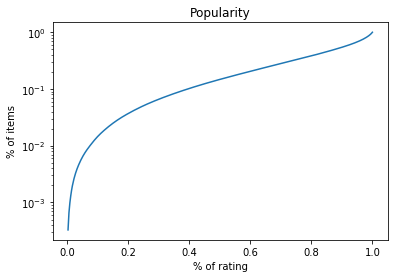

In [181]:
plt.plot(ordered_popularity.rating_percent_acum, ordered_popularity.movies_percent_acum)
plt.yscale("log")
plt.title("Popularity")
plt.xlabel("% of rating")
plt.ylabel("% of items")

In [185]:
filter_popular = ordered_popularity[ordered_popularity.rating_percent_acum < 0.33]
popular_movies = filter_popular.index

In [190]:
T_head = data_test[data_test.movie_id.isin(popular_movies)]
T_long = data_test[np.logical_not(data_test.movie_id.isin(popular_movies))]

In [219]:
def precision_recall_split(df, test_frac=0.014):
    df = remove_unrated(df, 20)
    data_test = df.sample(frac=test_frac)
    data_train = df.loc[~df.index.isin(data_test.index)]
    data_test = data_test[data_test.rating == 5]
    ordered_popularity = df.groupby("movie_id").agg({"rating": "count"}).sort_values(by="rating", ascending=False)
    total = ordered_popularity.rating.sum()
    ordered_popularity["rating_percent"] = ordered_popularity.rating / total
    ordered_popularity["rating_percent_acum"] = np.cumsum(ordered_popularity.rating_percent.to_numpy())
    
    filter_popular = ordered_popularity[ordered_popularity.rating_percent_acum < 0.3]
    popular_movies = filter_popular.index
    T_head = data_test[data_test.movie_id.isin(popular_movies)]
    T_long = data_test[np.logical_not(data_test.movie_id.isin(popular_movies))]
    return data_train, data_test,T_head, T_long

In [220]:
data_train, data_test, T_head, T_long = precision_recall_split(df)

Filtered movies  3043


In [238]:
user_item = get_user_item(data_train)
slim = SLIM()
slim.fit(user_item)

Training for item  500
loss  0.3641565737817958
Training for item  1000
loss  0.4579086648843155
Training for item  1500
loss  0.42134658589494567
Training for item  2000
loss  0.4006384389083255
Training for item  2500
loss  0.398113680658649
Training for item  3000
loss  0.3827597150119614


In [269]:
def compute_hits(slim, top_N, data_test):
    hits = 0
    user_index = slim.user_item.index.to_numpy()
    for i, r in data_test.iterrows():
        user_id = r["user_id"]
        movie_id = r["movie_id"]
        ix = np.where(user_index == user_id)
        hits = hits+1 if movie_id in top_N[ix,:] else hits
    return hits

In [265]:
N_max = 20
top_N_data_test = slim.all_useres_recomendation_precision_recall(N=N_max)
top_N_T_head = slim.all_useres_recomendation_precision_recall(N=N_max)
top_N_T_long = slim.all_useres_recomendation_precision_recall(N=N_max)

In [266]:
def compute_precision_recall_by_N(slim, top_N, data_test):
    N_max = top_N.shape[1]
    acum_recall = []
    acum_precision = []
    for n in range(1, N_max):
        computed_hits = compute_hits(slim, top_N[:,:n], data_test)
        recall = computed_hits / data_test.shape[0]
        precision = recall/n
        acum_recall.append(recall)
        acum_precision.append(precision)
    return acum_recall, acum_precision

In [270]:
acum_recall_data_test, acum_precision_data_test = compute_precision_recall_by_N(slim, top_N_data_test, data_test)
acum_recall_T_head, acum_precision_T_head = compute_precision_recall_by_N(slim, top_N_T_head, T_head)
acum_recall_T_long, acum_precision_T_long = compute_precision_recall_by_N(slim, top_N_T_long, T_long)

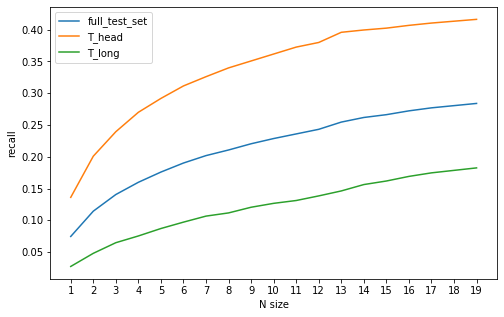

In [279]:
N_range = range(1,N_max)
plt.figure(figsize=(8,5))
plt.plot(N_range, acum_recall_data_test, label="full_test_set")
plt.plot(N_range, acum_recall_T_head, label="T_head")
plt.plot(N_range, acum_recall_T_long, label="T_long")
plt.xticks(N_range)
plt.xlabel("N size")
plt.ylabel("recall")
plt.legend()

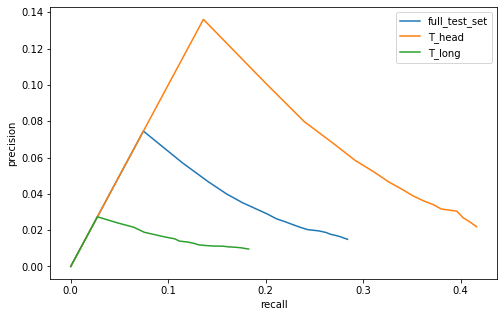

In [282]:
plt.figure(figsize=(8,5))
plt.plot([0]+acum_recall_data_test, [0]+acum_precision_data_test, label="full_test_set")
plt.plot([0]+acum_recall_T_head, [0]+acum_precision_T_head, label="T_head")
plt.plot([0]+acum_recall_T_long, [0]+acum_precision_T_long, label="T_long")
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend()